# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Configs
sns.set_theme()

Variable Name	Description
Item_Identifier	Unique product ID
Item_Weight	Weight of product
Item_Fat_Conten Whether the product is low fat or regular
Item_Visibility	The percentage of total display area of all products in a store allocated to the particular product
Item_Type	The category to which the product belongs
Item_MRP	Maximum Retail Price (list price) of the product
Outlet_Identifier	Unique store ID
Outlet_Establishment_Year	The year in which store was established
Outlet_Size	The size of the store in terms of ground area covered
Outlet_Location_Type	The type of area in which the store is located
Outlet_Type	Whether the outlet is a grocery store or some sort of supermarket
Item_Outlet_Sales	Sales of the product in the particular store. This is the target variable to be predicted.

In [2]:
# Load data
filename = 'sales_data_original.csv'
sales_df = pd.read_csv(filename)
sales_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Exploring Data

In [3]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
sales_df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Dealing with null values
Based on this article: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779
It makes sense to use either imputation of most frequen or by KNN for Outlet_Size and
imputation by mean for Item_Weight

In [5]:
sales_df.groupby(['Outlet_Size']).size()

Outlet_Size
High       932
Medium    2793
Small     2388
dtype: int64

In [6]:
max_weight, min_weight = sales_df['Item_Weight'].max(), sales_df['Item_Weight'].min()
print(f"Max weight = {max_weight} | Min weight = {min_weight}")

Max weight = 21.35 | Min weight = 4.555


In [7]:
# Imputing using mean for Item_Weight
sales_df['Item_Weight'].fillna(value=sales_df['Item_Weight'].mean(), inplace=True)

# Imputing using most frequent for Outlet_Size
sales_df['Outlet_Size'].fillna(value=sales_df['Outlet_Size'].mode().iloc[0], inplace=True)

In [8]:
sales_df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Dealing with irregular values

In [9]:
sales_df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [10]:
replace_dict = {'LF':'Low Fat', 'reg':'Regular', 'low fat':'Low Fat'}
sales_df.replace(replace_dict, inplace = True)

### Finding and Dealith With Outliers

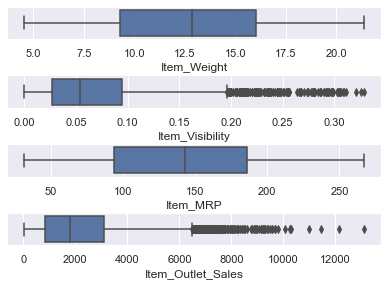

In [11]:
continuous_variables = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
fig, axes = plt.subplots(len(continuous_variables), 1)
fig.tight_layout()
for i in range(len(continuous_variables)):
    sns.boxplot(x=sales_df[continuous_variables[i]], ax=axes[i]);

#### Understanding Outliers
Outliers can either be erroneous or an actual part of the data. We'll try to understand what kind of outliers these are and if they are erroneous or a feature of the data.

Outliers exist in 'Item_Visibility' and 'Item_Outlet_Sales'. We'll isolate these using zscore.

In [12]:
sales_df['ZScore1'] = np.abs(zscore(sales_df['Item_Visibility']))
sales_df['ZScore2'] = np.abs(zscore(sales_df['Item_Outlet_Sales']))

outlier_filter = (sales_df['ZScore1'] > 3) | (sales_df['ZScore2'] > 3)
sales_df_outliers = sales_df[outlier_filter]

In [13]:
# Checking if there is a correlation between the two outliers.
sales_df_outliers[['ZScore1', 'ZScore2']].corr()

,ZScore1,ZScore2
ZScore1,1.000000,-0.891811
ZScore2,-0.891811,1.000000


In [14]:
sales_df_outliers[['Item_Visibility', 'Item_Outlet_Sales', 'ZScore1', 'ZScore2']]

,Item_Visibility,Item_Outlet_Sales,ZScore1,ZScore2
49,0.255395,780.3176,3.668255,0.821010
83,0.293418,583.2408,4.405207,0.936503
108,0.278974,679.1160,4.125262,0.880317
130,0.033810,7968.2944,0.626461,3.391354
145,0.039356,7370.4060,0.518969,3.040974
...,...,...,...,...
8245,0.035967,7549.5062,0.584650,3.145932
8273,0.297313,368.8532,4.480697,1.062140
8345,0.266397,641.1654,3.881490,0.902557
8432,0.227261,159.7920,3.122963,1.184656


In [15]:
print(sales_df_outliers[sales_df_outliers['Item_Outlet_Sales'] > 1000]['Outlet_Type'].value_counts())
print(sales_df_outliers[sales_df_outliers['Item_Outlet_Sales'] < 1000]['Outlet_Type'].value_counts())

Supermarket Type3    60
Supermarket Type1    30
Grocery Store         2
Name: Outlet_Type, dtype: int64
Grocery Store    93
Name: Outlet_Type, dtype: int64


The outliers seem to have something to do with 'Outlet_Type'. When 'Outlet_Type' is a 'Grocery Store' for example, visibility is high (relatively) but item sales remain low. The inverse is true when 'Outlet Type' is 'Supermarket'.

Because there is not enough known about the dataset, especially regarding units, dropping the outliers instead.

In [16]:
# Dropping outliers
sales_df['ZScore1'] = np.abs(zscore(sales_df['Item_Visibility']))
sales_df['ZScore2'] = np.abs(zscore(sales_df['Item_Outlet_Sales']))

outlier_filter = (sales_df['ZScore1'] > 1.5) | (sales_df['ZScore2'] > 1.5)
sales_df = sales_df[~outlier_filter]
sales_df.drop(columns=['ZScore1', 'ZScore2'], inplace=True)
sales_df.reset_index(inplace=True)

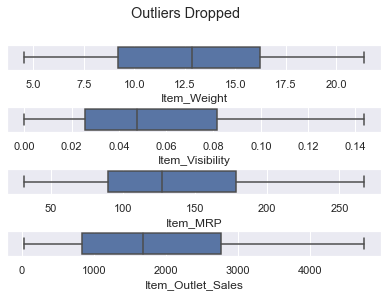

In [17]:
continuous_variables = ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']
fig, axes = plt.subplots(len(continuous_variables), 1)
fig.suptitle('Outliers Dropped')
fig.tight_layout()
for i in range(len(continuous_variables)):
    sns.boxplot(x=sales_df[continuous_variables[i]], ax=axes[i]);
    


### Exporting dataset.

In [18]:
sales_df.to_csv('sales_data.csv')